In [1]:
import kagglehub
import os
import shutil
import glob
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import random
from pathlib import Path

In [3]:
data_folder = "./datasets/Hand-Detection-Data"

base_path = Path('datasets/Hand-Detection-Data/1')
train_img_dir = base_path / 'train/images'
train_lbl_dir = base_path / 'train/labels/YOLO'

val_img_dir = base_path / 'valid/images'
val_lbl_dir = base_path / 'valid/labels/YOLO'

In [2]:
# Download latest version
path = kagglehub.dataset_download("nomihsa965/hand-detection-dataset-vocyolo-format")

os.makedirs(data_folder, exist_ok=True)

# Move the downloaded files to the specified relative path
shutil.move(path, os.path.join(data_folder, os.path.basename(path)))

print("Path to dataset files:", os.path.join(data_folder, os.path.basename(path)))

100%|██████████| 73.7M/73.7M [00:02<00:00, 26.3MB/s]

Extracting model files...


Path to dataset files: ./datasets/Hand-Detection-Data\1


In [3]:
# Create validation directories if they don't exist
val_img_dir.mkdir(parents=True, exist_ok=True)
val_lbl_dir.mkdir(parents=True, exist_ok=True)

# Parameters
VAL_RATIO = 0.15  # use 15% for validation

# Get all training images
image_files = list(train_img_dir.glob('*.jpg')) + list(train_img_dir.glob('*.png'))
random.shuffle(image_files)

# Split out a validation set
val_count = int(len(image_files) * VAL_RATIO)
val_images = image_files[:val_count]

# Move val files to new directories
for img_path in val_images:
    label_path = train_lbl_dir / (img_path.stem + '.txt')
    
    if label_path.exists():
        shutil.move(str(img_path), val_img_dir / img_path.name)
        shutil.move(str(label_path), val_lbl_dir / label_path.name)
    else:
        print(f"⚠️ Label file missing for {img_path.name}, skipping.")

In [4]:
train_dir = os.path.abspath('./datasets/Hand-Detection-Data/1/train/images')
valid_dir = os.path.abspath('./datasets/Hand-Detection-Data/1/valid/images')
test_dir = os.path.abspath('./datasets/Hand-Detection-Data/1/test/images')

for d in [train_dir, test_dir]:
    print(f"{d} exists: {os.path.exists(d)}")

# Optional: Check how many image files are in each directory
train_images = glob.glob(os.path.join(train_dir, '*.jpg')) + \
               glob.glob(os.path.join(train_dir, '*.png'))
val_images = glob.glob(os.path.join(val_img_dir, '*.jpg')) + \
             glob.glob(os.path.join(val_img_dir, '*.png'))
test_images = glob.glob(os.path.join(test_dir, '*.jpg')) + \
              glob.glob(os.path.join(test_dir, '*.png'))

print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")
print(f"Number of test images: {len(test_images)}")


c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\train\images exists: True
c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\test\images exists: True
Number of training images: 2831
Number of validation images: 376
Number of test images: 582


Image path: c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\train\images\Poselet_10.jpg
Label path: c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\train\labels\YOLO\Poselet_10.txt
✅ Label file contents:
0 0.2353515625 0.7317708333333334 0.0712890625 0.09375
0 0.3818359375 0.87890625 0.0712890625 0.11979166666666667
0 0.4970703125 0.8346354166666666 0.09765625 0.12630208333333334
0 0.4970703125 0.8346354166666666 0.09765625 0.12630208333333334



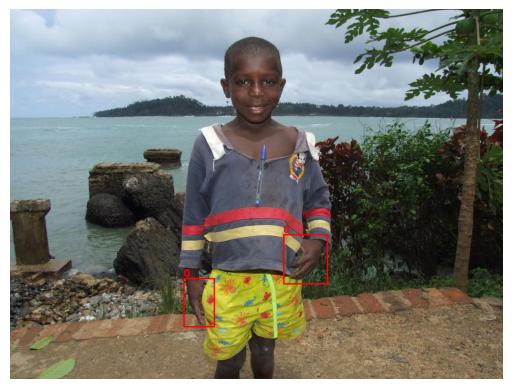

In [9]:
sample_img_path = train_images[0]  # e.g., .../train/images/VOC2007_175.jpg

# Extract just the filename without extension
basename = os.path.basename(sample_img_path).rsplit('.', 1)[0]  # VOC2007_175
label_path = os.path.join(
    os.path.dirname(sample_img_path).replace('images', 'labels\\YOLO'),
    f"{basename}.txt"
)

print("Image path:", sample_img_path)
print("Label path:", label_path)

# Check if file exists
if not os.path.exists(label_path):
    print("❌ Label file not found!")
else:
    with open(label_path, 'r') as f:
        print("✅ Label file contents:")
        print(f.read())

def show_image_with_bboxes(img_path):
    import os

    # Get base name like "VOC2007_175"
    basename = os.path.basename(img_path).rsplit('.', 1)[0]

    # Get path to YOLO label file
    label_path = os.path.join(
        os.path.dirname(img_path).replace(f"{os.sep}images", f"{os.sep}labels{os.sep}YOLO"),
        f"{basename}.txt"
    )

    # Read and display image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Check for label file
    if not os.path.exists(label_path):
        print(f"❌ No label file found at {label_path}")
        plt.imshow(img)
        plt.title("No label file found")
        plt.axis('off')
        plt.show()
        return

    # Draw bounding boxes
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            cls_idx, x_c, y_c, bbox_w, bbox_h = map(float, line.strip().split())
            x_c *= w
            y_c *= h
            bbox_w *= w
            bbox_h *= h
            x1 = int(x_c - bbox_w / 2)
            y1 = int(y_c - bbox_h / 2)
            x2 = int(x_c + bbox_w / 2)
            y2 = int(y_c + bbox_h / 2)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img, str(int(cls_idx)), (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    plt.imshow(img)
    plt.axis('off')
    plt.show()
# Display random training image with bounding box
random_img = random.choice(train_images)
show_image_with_bboxes(random_img)


In [10]:
# Move the labels for the YOLO out of the nested directory

base = Path("datasets/Hand-Detection-Data/1")

for split in ['train', 'valid', 'test']:
    yolodir = base / split / 'labels' / 'YOLO'
    targetdir = base / split / 'labels'

    # Move all .txt files up one level
    for file in yolodir.glob("*.txt"):
        shutil.move(str(file), targetdir / file.name)
    
    # Optional: remove empty YOLO/ folder
    yolodir.rmdir()

In [11]:
#Step-by-Step Code to Create the Normalized Hand-Version
def create_hand_only_labels(src_root, dst_root):
    """
    Copies YOLO images and labels from `src_root` to `dst_root`,
    and replaces all class IDs with 0 for hand detection.
    """

    src_root = Path(src_root)
    dst_root = Path(dst_root)
    
    for split in ['train', 'valid', 'test']:
        src_img_dir = src_root / split / 'images'
        src_lbl_dir = src_root / split / 'labels'

        dst_img_dir = dst_root / split / 'images'
        dst_lbl_dir = dst_root / split / 'labels'

        dst_img_dir.mkdir(parents=True, exist_ok=True)
        dst_lbl_dir.mkdir(parents=True, exist_ok=True)

        for img_file in src_img_dir.glob("*.jpg"):
            shutil.copy(img_file, dst_img_dir / img_file.name)

        for label_file in src_lbl_dir.glob("*.txt"):
            with open(label_file, 'r') as f:
                lines = f.readlines()
            
            new_lines = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    parts[0] = '0'  # normalize class label to 0 (for "hand")
                    new_lines.append(" ".join(parts))

            with open(dst_lbl_dir / label_file.name, 'w') as f:
                f.write("\n".join(new_lines))

        print(f"✅ Processed {split} set: {len(list(dst_img_dir.glob('*.jpg')))} images")

# Run conversion
create_hand_only_labels(
    src_root="datasets/Letter-Classification-Data",
    dst_root="datasets/Letter-HandDetection-Version"
)

✅ Processed train set: 1512 images
✅ Processed valid set: 144 images
✅ Processed test set: 72 images


In [12]:
# Merge the Normalized Version Into Your Hand Detection Dataset
def merge_to_hand_dataset(letter_set, hand_set):
    letter_img_dir = Path(f"datasets/Letter-HandDetection-Version/{letter_set}/images")
    letter_lbl_dir = Path(f"datasets/Letter-HandDetection-Version/{letter_set}/labels")
    
    hand_img_dir = Path(f"datasets/Hand-Detection-Data/1/{hand_set}/images")
    hand_lbl_dir = Path(f"datasets/Hand-Detection-Data/1/{hand_set}/labels")

    hand_img_dir.mkdir(parents=True, exist_ok=True)
    hand_lbl_dir.mkdir(parents=True, exist_ok=True)

    for img_file in letter_img_dir.glob("*.jpg"):
        shutil.copy(img_file, hand_img_dir / img_file.name)

    for lbl_file in letter_lbl_dir.glob("*.txt"):
        shutil.copy(lbl_file, hand_lbl_dir / lbl_file.name)

# Merge each set
merge_to_hand_dataset("train", "train")
merge_to_hand_dataset("valid", "valid")
merge_to_hand_dataset("test", "test")

In [5]:
# Load a pretrained YOLOv8 model (use yolov8n.pt for lightweight testing)
yaml_path = Path('datasets/Hand-Detection-Data/1/data.yaml').resolve()

print("Using data.yaml path:", yaml_path)

model = YOLO('yolov8m.pt')


Using data.yaml path: C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\data.yaml


In [ ]:
metrics = model.val()
#print(metrics)

Ultralytics 8.3.96  Python-3.12.3 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
YOLOv8m summary (fused): 92 layers, 25,886,080 parameters, 0 gradients, 78.9 GFLOPs

Dataset 'coco.yaml' images not found , missing path 'C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\coco\val2017.txt'


100%|██████████| 169M/169M [00:03<00:00, 50.4MB/s] 
Unzipping C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\coco2017labels-segments.zip to C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\coco...: 100%|██████████| 122232/122232 [01:17<00:00, 1584.39file/s]


In [6]:
model.train(
    data=str(yaml_path),  # <--- pass as string
    epochs=50,
    imgsz=640,
    batch=8,
    name='hand-detect-medium-v16',
    project='runs/detect'
)

New https://pypi.org/project/ultralytics/8.3.99 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.96  Python-3.12.3 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/detect, name=hand-detect-medium-v16, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False

train: Scanning C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\train\labels.cache... 2831 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2831/2831 [00:00<?, ?it/s]

train: WARNING  C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\train\images\Poselet_10.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\train\images\Poselet_180.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\train\images\Poselet_247.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\train\images\Poselet_268.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\train\images\Poselet_290.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\train\images\Poselet_298.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-D


val: Scanning C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\valid\labels.cache... 376 images, 0 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]

val: WARNING  C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\valid\images\Poselet_282.jpg: 1 duplicate labels removed
val: WARNING  C:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\valid\images\VOC2010_723.jpg: 1 duplicate labels removed


Plotting labels to runs\detect\hand-detect-medium-v16\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\hand-detect-medium-v16
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.14G      1.594      1.734      1.709         12        640: 100%|██████████| 354/354 [01:20<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.26it/s]

                   all        376        569      0.184      0.279      0.108     0.0456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.21G      1.689      1.873      1.781         16        640: 100%|██████████| 354/354 [01:12<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  6.38it/s]

                   all        376        569      0.424      0.383      0.361      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.28G      1.638      1.754      1.716         22        640: 100%|██████████| 354/354 [01:15<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  6.04it/s]

                   all        376        569      0.677      0.511      0.595      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.28G       1.55      1.638      1.663         15        640: 100%|██████████| 354/354 [01:12<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.98it/s]

                   all        376        569      0.647      0.557      0.607      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.28G      1.534      1.542      1.631         24        640: 100%|██████████| 354/354 [01:13<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  6.00it/s]

                   all        376        569      0.731      0.563      0.654      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.28G      1.436      1.409      1.566         13        640: 100%|██████████| 354/354 [01:12<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  6.09it/s]

                   all        376        569      0.773       0.61      0.712      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.31G      1.411       1.36      1.546         16        640: 100%|██████████| 354/354 [01:15<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.44it/s]

                   all        376        569      0.835      0.617      0.742      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.31G      1.394      1.283      1.538         22        640: 100%|██████████| 354/354 [01:16<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.54it/s]

                   all        376        569      0.838      0.652      0.768      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.31G      1.364      1.238      1.515         19        640: 100%|██████████| 354/354 [01:15<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.32it/s]

                   all        376        569      0.794      0.691      0.801       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.38G      1.322      1.181      1.483         22        640: 100%|██████████| 354/354 [01:14<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.82it/s]

                   all        376        569      0.784      0.643      0.748      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.45G      1.309      1.136      1.462         20        640: 100%|██████████| 354/354 [01:12<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  6.15it/s]

                   all        376        569      0.809       0.69      0.803      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.04G      1.287      1.085      1.452         16        640: 100%|██████████| 354/354 [01:13<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  6.17it/s]

                   all        376        569      0.795      0.747      0.816      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.04G       1.26      1.049      1.437         21        640: 100%|██████████| 354/354 [01:11<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  6.25it/s]

                   all        376        569      0.824        0.7      0.813      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.04G      1.248      1.036      1.429         19        640: 100%|██████████| 354/354 [01:12<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  6.00it/s]

                   all        376        569      0.785      0.707      0.798      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.04G      1.237      1.019      1.412         14        640: 100%|██████████| 354/354 [01:13<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.34it/s]

                   all        376        569      0.847      0.735       0.84      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.04G      1.223     0.9786      1.408         15        640: 100%|██████████| 354/354 [01:17<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.47it/s]

                   all        376        569      0.859      0.761      0.852      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.04G      1.219     0.9774      1.392         10        640: 100%|██████████| 354/354 [01:16<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.46it/s]

                   all        376        569      0.888      0.745      0.853      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.04G      1.195     0.9427      1.377         22        640: 100%|██████████| 354/354 [01:17<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.31it/s]

                   all        376        569      0.882       0.75      0.856       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.04G      1.166     0.8968      1.361         10        640: 100%|██████████| 354/354 [01:16<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.48it/s]

                   all        376        569      0.857      0.763      0.866      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.04G      1.189     0.9168      1.376         12        640: 100%|██████████| 354/354 [01:17<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.51it/s]

                   all        376        569      0.845       0.77      0.862      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.04G      1.157     0.8728      1.358         28        640: 100%|██████████| 354/354 [01:16<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.69it/s]

                   all        376        569      0.902      0.757      0.872      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.04G      1.163     0.8638       1.36         25        640: 100%|██████████| 354/354 [01:17<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.82it/s]

                   all        376        569      0.849      0.793      0.879      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.04G      1.134     0.8338      1.341         15        640: 100%|██████████| 354/354 [01:16<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.57it/s]

                   all        376        569      0.905      0.752      0.871      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.04G      1.132     0.8225       1.34         17        640: 100%|██████████| 354/354 [01:17<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.56it/s]

                   all        376        569      0.906      0.773      0.882      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.04G      1.112     0.7939      1.329         10        640: 100%|██████████| 354/354 [01:17<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.19it/s]

                   all        376        569       0.85      0.809      0.887      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.04G      1.095     0.7904       1.31         14        640: 100%|██████████| 354/354 [01:17<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.34it/s]

                   all        376        569      0.889      0.777      0.879      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.04G      1.093     0.7749      1.306         21        640: 100%|██████████| 354/354 [01:16<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.48it/s]

                   all        376        569      0.918      0.763       0.88      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.04G      1.079      0.764      1.313         13        640: 100%|██████████| 354/354 [01:16<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.52it/s]

                   all        376        569      0.906      0.779      0.886       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.04G       1.07     0.7455      1.301         18        640: 100%|██████████| 354/354 [01:16<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.63it/s]

                   all        376        569      0.896      0.779      0.875      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.04G      1.062      0.739      1.291         12        640: 100%|██████████| 354/354 [01:17<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.42it/s]

                   all        376        569      0.904      0.763      0.887      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.04G      1.058     0.7129      1.282         12        640: 100%|██████████| 354/354 [01:17<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.02it/s]

                   all        376        569        0.9      0.779      0.879      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.04G       1.04     0.7005      1.272         20        640: 100%|██████████| 354/354 [01:16<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.29it/s]

                   all        376        569      0.898       0.77      0.882       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.04G      1.021      0.689      1.273         16        640: 100%|██████████| 354/354 [01:17<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.34it/s]

                   all        376        569      0.888      0.796      0.892      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.04G      1.024     0.6868      1.269         15        640: 100%|██████████| 354/354 [01:18<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.10it/s]

                   all        376        569      0.903      0.803      0.894      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.04G       1.01     0.6698      1.258         24        640: 100%|██████████| 354/354 [01:18<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.02it/s]

                   all        376        569      0.898      0.793      0.891      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.04G      1.005     0.6654      1.258         26        640: 100%|██████████| 354/354 [01:16<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.08it/s]

                   all        376        569      0.881      0.796      0.891       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.04G     0.9599     0.6268      1.227         29        640: 100%|██████████| 354/354 [01:17<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.38it/s]

                   all        376        569      0.906      0.803      0.905      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.04G     0.9598     0.6135      1.227         27        640: 100%|██████████| 354/354 [01:17<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.48it/s]

                   all        376        569      0.869      0.818        0.9      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.04G     0.9647     0.6172      1.228         16        640: 100%|██████████| 354/354 [01:17<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.84it/s]

                   all        376        569      0.907       0.79      0.894       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.04G     0.9386     0.6062      1.207         19        640: 100%|██████████| 354/354 [01:12<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.99it/s]

                   all        376        569      0.896      0.803      0.904      0.585


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.04G     0.8433     0.4928      1.163          8        640: 100%|██████████| 354/354 [01:13<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.62it/s]

                   all        376        569       0.91      0.791      0.901      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.04G     0.8227     0.4643      1.155         12        640: 100%|██████████| 354/354 [01:15<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.12it/s]

                   all        376        569      0.865      0.844      0.911      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.04G     0.8163     0.4502       1.16          8        640: 100%|██████████| 354/354 [01:17<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.62it/s]

                   all        376        569      0.881      0.828        0.9      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.04G     0.7961     0.4367      1.132          9        640: 100%|██████████| 354/354 [01:14<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  6.22it/s]

                   all        376        569      0.885      0.852      0.916      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.04G     0.7756     0.4274      1.126         13        640: 100%|██████████| 354/354 [01:12<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  6.06it/s]

                   all        376        569      0.862      0.859      0.911      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.04G     0.7578     0.4115      1.113          9        640: 100%|██████████| 354/354 [01:12<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.93it/s]

                   all        376        569       0.88      0.826      0.909      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.04G     0.7538     0.3966       1.11         10        640: 100%|██████████| 354/354 [01:13<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  6.15it/s]

                   all        376        569      0.929      0.779      0.907      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.04G       0.74     0.3941      1.096         14        640: 100%|██████████| 354/354 [01:12<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.74it/s]

                   all        376        569      0.886       0.83       0.91      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.04G     0.7278      0.384      1.093          7        640: 100%|██████████| 354/354 [01:12<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  6.24it/s]

                   all        376        569      0.904      0.824       0.91      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.04G      0.714     0.3731      1.081         10        640: 100%|██████████| 354/354 [01:11<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  6.33it/s]

                   all        376        569      0.887      0.827      0.911      0.603



50 epochs completed in 1.139 hours.
Optimizer stripped from runs\detect\hand-detect-medium-v16\weights\last.pt, 52.0MB
Optimizer stripped from runs\detect\hand-detect-medium-v16\weights\best.pt, 52.0MB

Validating runs\detect\hand-detect-medium-v16\weights\best.pt...
Ultralytics 8.3.96  Python-3.12.3 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.86it/s]


                   all        376        569      0.884       0.83       0.91      0.609
Speed: 0.2ms preprocess, 5.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\hand-detect-medium-v16


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001A12D0D1700>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [8]:
results = model.predict(
    source='datasets/Hand-Detection-Data/1/test/images',
    conf=0.25,
    save=True  # saves annotated predictions to disk
)


image 1/582 c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\test\images\A22_jpg.rf.f02ad8558ce1c88213b4f83c0bc66bc8.jpg: 640x640 1 hand, 90.2ms
image 2/582 c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\test\images\B14_jpg.rf.ed5ba6d44f55ab03e62d2baeac4aa1aa.jpg: 640x640 1 hand, 16.9ms
image 3/582 c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\test\images\B15_jpg.rf.0f0628552139144fc67c453e1f1b7b15.jpg: 640x640 1 hand, 12.7ms
image 4/582 c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\test\images\B19_jpg.rf.69527cc1f34d694cc04e55db80ed9b1a.jpg: 640x640 1 hand, 10.9ms
image 5/582 c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\test\images\C17_jpg.rf.ceb81f8ae3c3673bd060ebe71848eca8.jpg: 640x640 1 hand, 12.2ms
image 6/582 c:\Users\cjmij\DSAN\DSAN_6500\mini-project-3-cj\datasets\Hand-Detection-Data\1\test\images\C19_jpg.rf.577ce02a22

In [17]:
from PIL import Image

# Path to YOLO predictions folder
pred_dir = Path('runs/detect/hand-detect-medium-v162')

# Get list of prediction images (YOLO saves them in the root of the folder)
img_files = list(pred_dir.glob('*.jpg')) + list(pred_dir.glob('*.png'))

# Display the first prediction
if img_files:
    img = Image.open(img_files[150])
    img.show()
else:
    print("❌ No predicted images found in", pred_dir)

In [20]:
# Source: where YOLO saved the trained model
source_model_path = 'runs/detect/hand-detect-medium-v16/weights/best.pt'

# Destination: your streamlit app's model folder
dest_model_path = 'yolov8_medium_model/best_medium.pt'

# Copy
shutil.copy(source_model_path, dest_model_path)

print("✅ Model copied to yolov8_model/best.pt")

✅ Model copied to yolov8_model/best.pt
